<a href="https://colab.research.google.com/github/AngKS/practices/blob/master/CIFAR10_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 GAN Model

Article link: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# load dataset
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
# summarize the shape of the dataset
print('Train', train_x.shape, train_y.shape)
print('Test', test_x.shape, test_y.shape)

Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


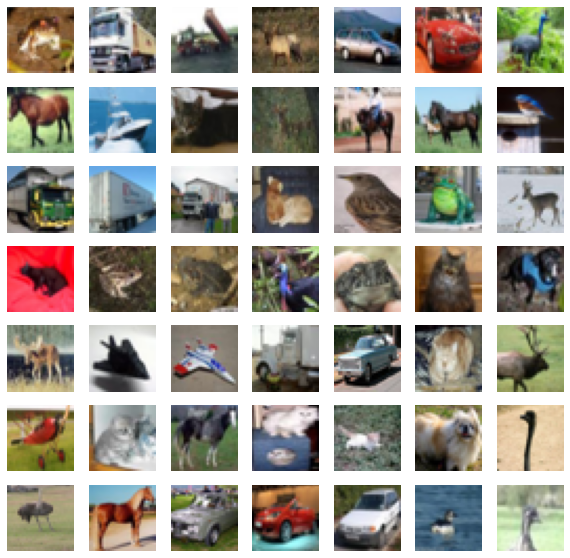

In [ ]:
# plot images from the training dataset
plt.figure(figsize=(10,10))
for i in range(49):
	# define subplot
	plt.subplot(7, 7, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(train_x[i])
plt.show()

In [ ]:
# import keras components
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

In [ ]:
# define the standalone descriminator model

def define_desc(in_shape=(32, 32, 3)):
  model = Sequential()
  model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  # Downsampling
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # Classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
  

In [ ]:
desc_model = define_desc()
desc_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
def load_real_samples():
    (train_x, _), (_, _) = tf.keras.datasets.cifar10.load_data()

    X = train_x.astype('float32')
    # scale the images from [0,255] to [-1,1]
    
    X = (X - 127.5) / 127.5

    return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
  X = dataset[ix]
	# generate 'real' class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    X_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(X_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [ ]:
# define the generator model

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # upsample to 8X8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # upsample to 16X16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # Upsample to 32X32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model


In [ ]:
# define size of latent space
latent_dim = 100
gen_model = define_generator(latent_dim)
gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                        

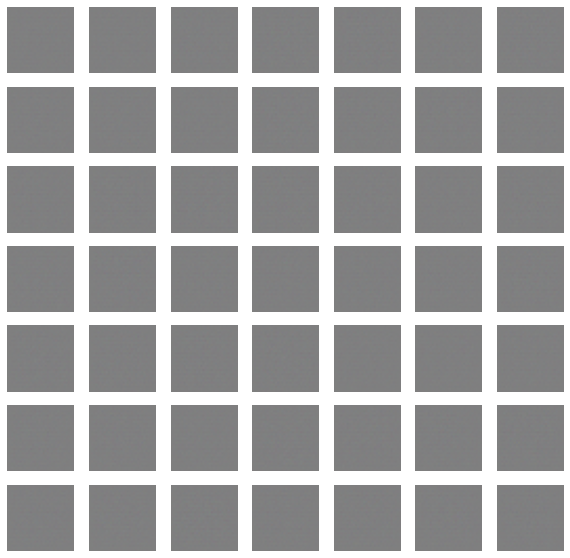

In [ ]:
# generate samples
n_samples = 49
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# Scale X from [-1, 1] to [0, 1]
X = (X + 1) / 2.0

plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(7, 7, i+1)
    plt.axis('off')
    plt.imshow(X[i])
plt.show()

In [ ]:
def define_GAN(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
latent_dim = 100
d_model = define_desc()
g_model = define_generator(latent_dim)
gan_model = define_GAN(g_model, d_model)
gan_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 32, 32, 3)         1467651   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 519425    
                                                                 
Total params: 1,987,076
Trainable params: 1,466,883
Non-trainable params: 520,193
_________________________________________________________________


In [ ]:
def train_GAN(gan_model, latent_dim, epochs=200, batch_size=128):
    for i in range(epochs):
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))
        gan_model.train_on_batch(x_gan, y_gan)



In [ ]:
def create_plots(epoch, examples, real, n):
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.axis('off')
        plt.title(f"Epoch {epoch}")
        plt.imshow((examples[i, :, :]).astype('float32'))

    
    plt.show()


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, epochs=100, batch_size=128):
    bat_per_epo = int(dataset.shape[0] / batch_size)
    half_batch = batch_size // 2
    for i in range(epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update descriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space for generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size, 1))
            # update generator loss
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        print(f"Epoch: {i + 1} / {epochs}   Descriminator Loss[1]: {d_loss1:.3f}    Descriminator Loss[2]: {d_loss2:.3f}    GAN loss: {g_loss:.3f}")
        if (i % 5 == 0):
            create_plots(i, g_model.predict(generate_latent_points(100, 100)),X_real, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 / 100   Descriminator Loss[1]: 0.694    Descriminator Loss[2]: 0.672    GAN loss: 0.988


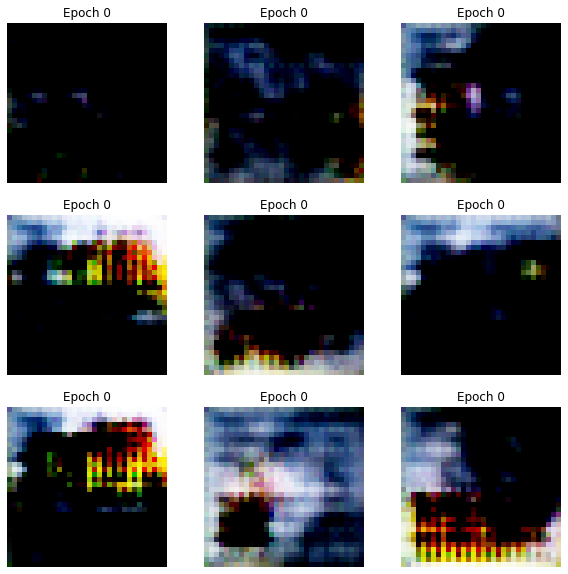

Epoch: 2 / 100   Descriminator Loss[1]: 0.424    Descriminator Loss[2]: 0.319    GAN loss: 1.188
Epoch: 3 / 100   Descriminator Loss[1]: 0.369    Descriminator Loss[2]: 0.330    GAN loss: 0.892
Epoch: 4 / 100   Descriminator Loss[1]: 0.304    Descriminator Loss[2]: 0.337    GAN loss: 1.362
Epoch: 5 / 100   Descriminator Loss[1]: 0.424    Descriminator Loss[2]: 0.499    GAN loss: 1.209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6 / 100   Descriminator Loss[1]: 0.157    Descriminator Loss[2]: 0.211    GAN loss: 0.835


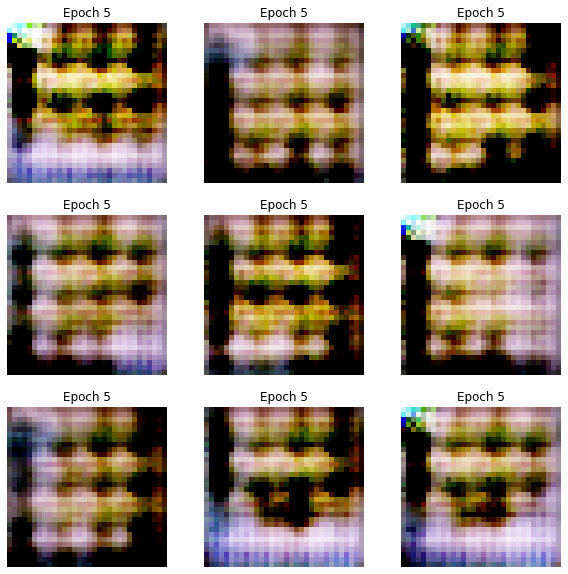

Epoch: 7 / 100   Descriminator Loss[1]: 0.318    Descriminator Loss[2]: 0.421    GAN loss: 1.976
Epoch: 8 / 100   Descriminator Loss[1]: 0.354    Descriminator Loss[2]: 0.192    GAN loss: 1.200
Epoch: 9 / 100   Descriminator Loss[1]: 0.627    Descriminator Loss[2]: 0.096    GAN loss: 3.244
Epoch: 10 / 100   Descriminator Loss[1]: 0.007    Descriminator Loss[2]: 0.032    GAN loss: 0.152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 / 100   Descriminator Loss[1]: 0.232    Descriminator Loss[2]: 0.110    GAN loss: 0.679


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


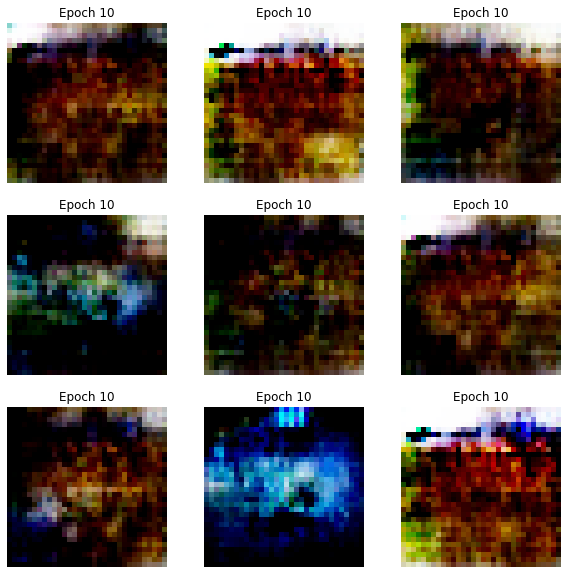

Epoch: 12 / 100   Descriminator Loss[1]: 0.519    Descriminator Loss[2]: 0.235    GAN loss: 1.565
Epoch: 13 / 100   Descriminator Loss[1]: 0.180    Descriminator Loss[2]: 0.220    GAN loss: 2.462
Epoch: 14 / 100   Descriminator Loss[1]: 0.694    Descriminator Loss[2]: 0.229    GAN loss: 2.406
Epoch: 15 / 100   Descriminator Loss[1]: 0.271    Descriminator Loss[2]: 0.209    GAN loss: 3.151


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16 / 100   Descriminator Loss[1]: 0.377    Descriminator Loss[2]: 0.199    GAN loss: 2.282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


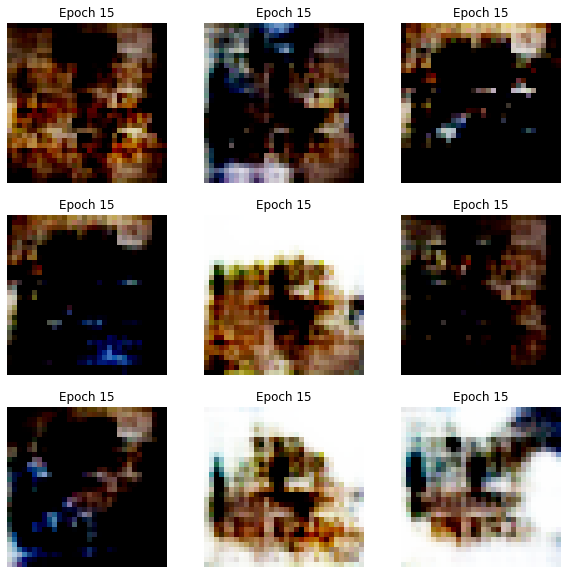

Epoch: 17 / 100   Descriminator Loss[1]: 0.081    Descriminator Loss[2]: 0.061    GAN loss: 0.040
Epoch: 18 / 100   Descriminator Loss[1]: 0.287    Descriminator Loss[2]: 0.280    GAN loss: 3.326
Epoch: 19 / 100   Descriminator Loss[1]: 0.421    Descriminator Loss[2]: 0.225    GAN loss: 2.260
Epoch: 20 / 100   Descriminator Loss[1]: 0.443    Descriminator Loss[2]: 0.325    GAN loss: 1.910


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21 / 100   Descriminator Loss[1]: 0.157    Descriminator Loss[2]: 0.114    GAN loss: 0.563


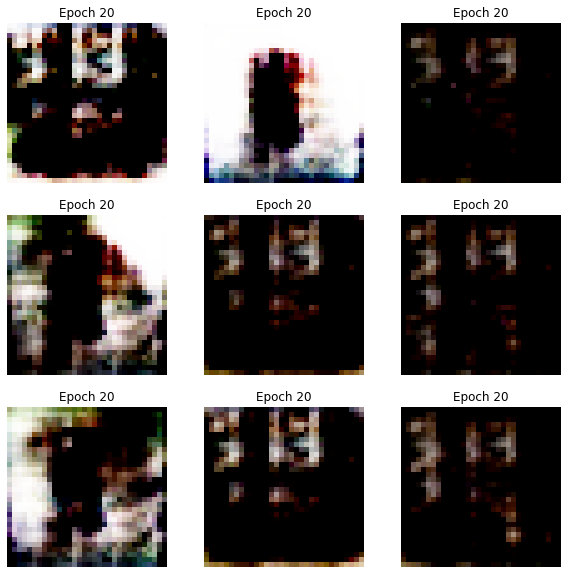

Epoch: 22 / 100   Descriminator Loss[1]: 0.429    Descriminator Loss[2]: 0.402    GAN loss: 2.156
Epoch: 23 / 100   Descriminator Loss[1]: 0.050    Descriminator Loss[2]: 0.037    GAN loss: 0.017
Epoch: 24 / 100   Descriminator Loss[1]: 0.312    Descriminator Loss[2]: 0.304    GAN loss: 1.638
Epoch: 25 / 100   Descriminator Loss[1]: 0.345    Descriminator Loss[2]: 0.155    GAN loss: 1.561


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 26 / 100   Descriminator Loss[1]: 0.028    Descriminator Loss[2]: 0.589    GAN loss: 2.822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


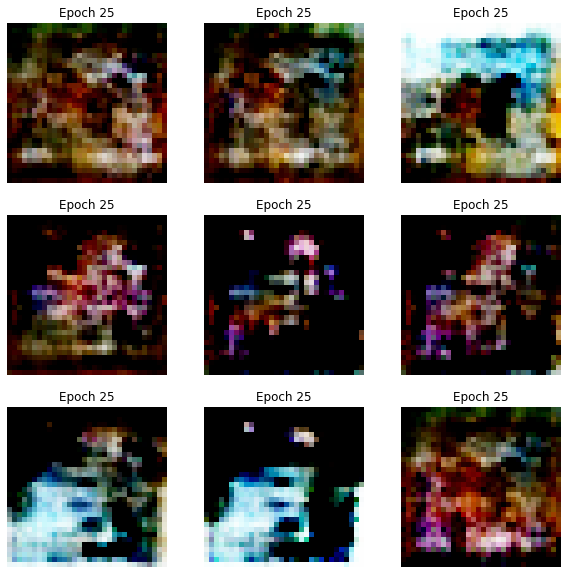

Epoch: 27 / 100   Descriminator Loss[1]: 0.242    Descriminator Loss[2]: 0.082    GAN loss: 2.413
Epoch: 28 / 100   Descriminator Loss[1]: 0.862    Descriminator Loss[2]: 0.233    GAN loss: 1.790
Epoch: 29 / 100   Descriminator Loss[1]: 0.331    Descriminator Loss[2]: 0.276    GAN loss: 2.079
Epoch: 30 / 100   Descriminator Loss[1]: 0.347    Descriminator Loss[2]: 0.208    GAN loss: 2.524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 31 / 100   Descriminator Loss[1]: 0.267    Descriminator Loss[2]: 0.120    GAN loss: 3.330


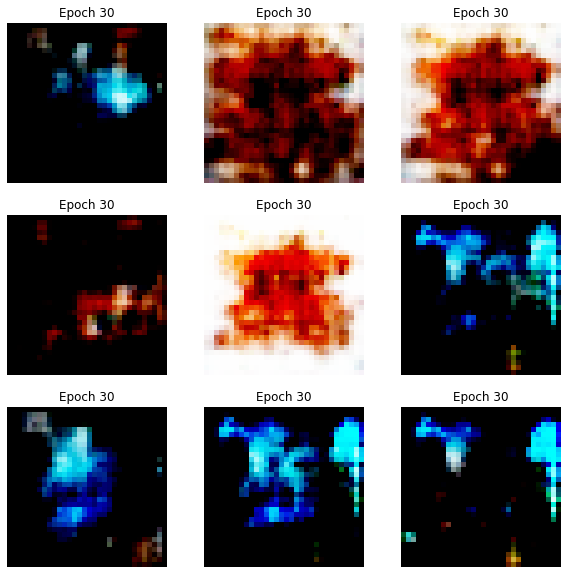

Epoch: 32 / 100   Descriminator Loss[1]: 0.192    Descriminator Loss[2]: 0.099    GAN loss: 3.921
Epoch: 33 / 100   Descriminator Loss[1]: 0.453    Descriminator Loss[2]: 0.272    GAN loss: 1.709
Epoch: 34 / 100   Descriminator Loss[1]: 0.385    Descriminator Loss[2]: 0.118    GAN loss: 1.743
Epoch: 35 / 100   Descriminator Loss[1]: 0.614    Descriminator Loss[2]: 0.249    GAN loss: 2.383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 36 / 100   Descriminator Loss[1]: 0.559    Descriminator Loss[2]: 0.236    GAN loss: 1.763


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


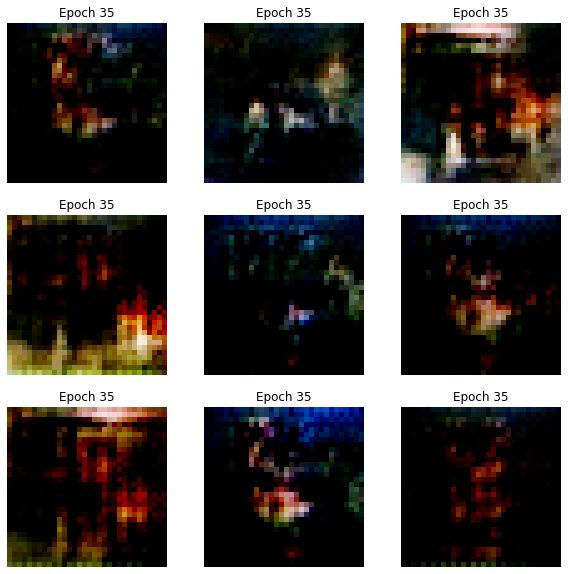

Epoch: 37 / 100   Descriminator Loss[1]: 0.505    Descriminator Loss[2]: 0.261    GAN loss: 3.535
Epoch: 38 / 100   Descriminator Loss[1]: 0.030    Descriminator Loss[2]: 0.043    GAN loss: 2.842
Epoch: 39 / 100   Descriminator Loss[1]: 0.072    Descriminator Loss[2]: 0.161    GAN loss: 3.098
Epoch: 40 / 100   Descriminator Loss[1]: 0.139    Descriminator Loss[2]: 0.086    GAN loss: 3.571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 41 / 100   Descriminator Loss[1]: 0.177    Descriminator Loss[2]: 0.148    GAN loss: 1.945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


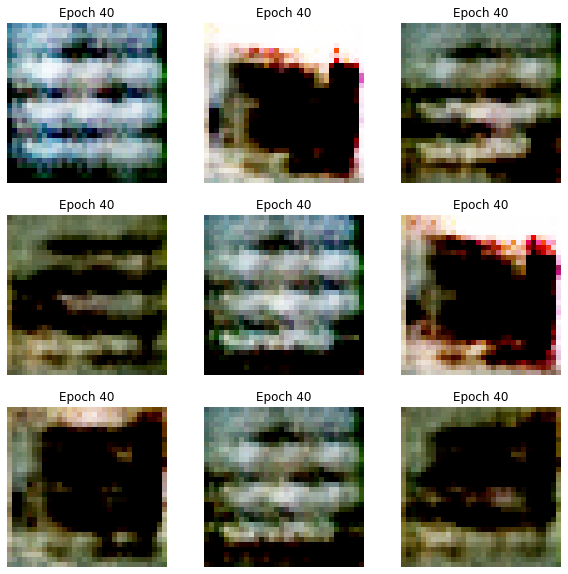

Epoch: 42 / 100   Descriminator Loss[1]: 0.053    Descriminator Loss[2]: 0.017    GAN loss: 0.075
Epoch: 43 / 100   Descriminator Loss[1]: 0.108    Descriminator Loss[2]: 0.127    GAN loss: 2.743
Epoch: 44 / 100   Descriminator Loss[1]: 0.237    Descriminator Loss[2]: 0.172    GAN loss: 2.846
Epoch: 45 / 100   Descriminator Loss[1]: 0.155    Descriminator Loss[2]: 0.036    GAN loss: 1.074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 46 / 100   Descriminator Loss[1]: 0.198    Descriminator Loss[2]: 0.144    GAN loss: 5.890


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


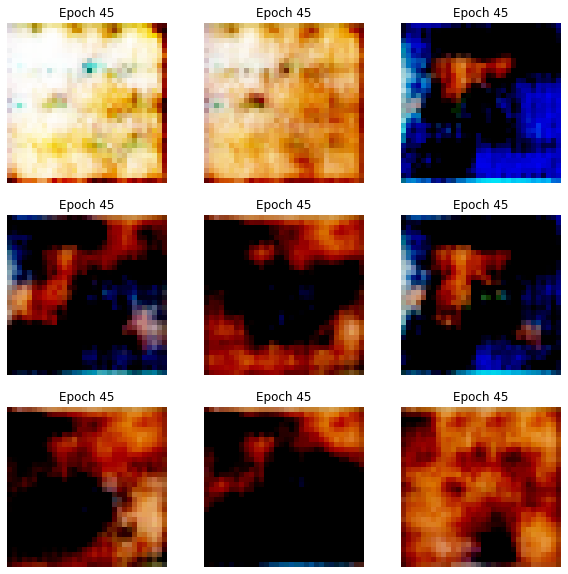

Epoch: 47 / 100   Descriminator Loss[1]: 0.197    Descriminator Loss[2]: 0.039    GAN loss: 0.506
Epoch: 48 / 100   Descriminator Loss[1]: 0.179    Descriminator Loss[2]: 0.099    GAN loss: 0.081
Epoch: 49 / 100   Descriminator Loss[1]: 0.172    Descriminator Loss[2]: 0.237    GAN loss: 0.808
Epoch: 50 / 100   Descriminator Loss[1]: 0.188    Descriminator Loss[2]: 0.237    GAN loss: 2.665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 51 / 100   Descriminator Loss[1]: 0.067    Descriminator Loss[2]: 0.026    GAN loss: 0.551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


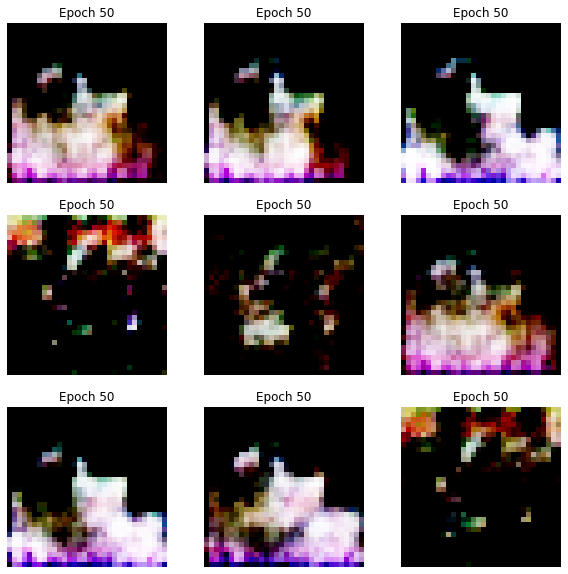

Epoch: 52 / 100   Descriminator Loss[1]: 0.089    Descriminator Loss[2]: 0.118    GAN loss: 0.907
Epoch: 53 / 100   Descriminator Loss[1]: 0.064    Descriminator Loss[2]: 0.051    GAN loss: 0.707
Epoch: 54 / 100   Descriminator Loss[1]: 0.373    Descriminator Loss[2]: 0.259    GAN loss: 4.050
Epoch: 55 / 100   Descriminator Loss[1]: 0.072    Descriminator Loss[2]: 0.139    GAN loss: 1.341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 56 / 100   Descriminator Loss[1]: 0.032    Descriminator Loss[2]: 0.018    GAN loss: 0.185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


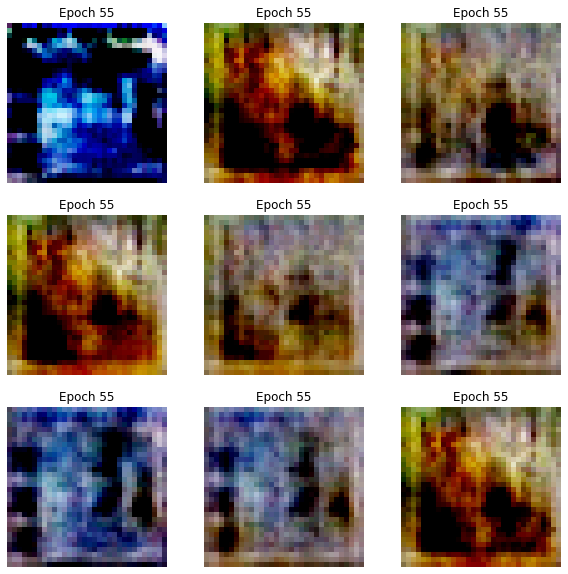

Epoch: 57 / 100   Descriminator Loss[1]: 0.328    Descriminator Loss[2]: 0.190    GAN loss: 2.152
Epoch: 58 / 100   Descriminator Loss[1]: 0.239    Descriminator Loss[2]: 0.141    GAN loss: 1.404
Epoch: 59 / 100   Descriminator Loss[1]: 0.171    Descriminator Loss[2]: 0.183    GAN loss: 2.383
Epoch: 60 / 100   Descriminator Loss[1]: 0.176    Descriminator Loss[2]: 0.044    GAN loss: 3.062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 61 / 100   Descriminator Loss[1]: 0.139    Descriminator Loss[2]: 0.080    GAN loss: 0.815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


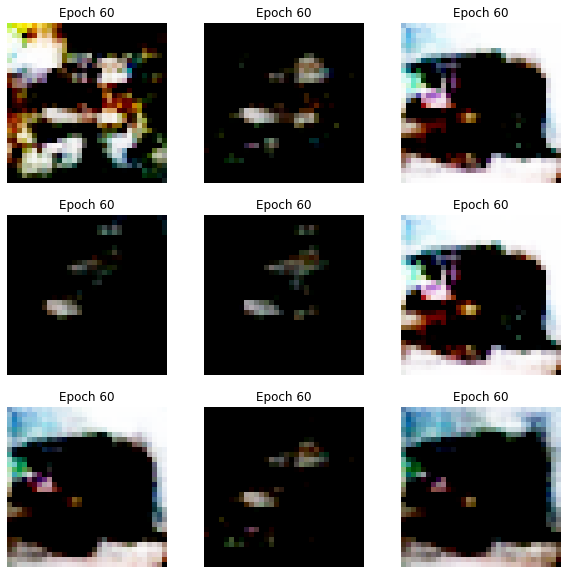

Epoch: 62 / 100   Descriminator Loss[1]: 0.150    Descriminator Loss[2]: 0.031    GAN loss: 2.693
Epoch: 63 / 100   Descriminator Loss[1]: 0.051    Descriminator Loss[2]: 0.071    GAN loss: 0.275
Epoch: 64 / 100   Descriminator Loss[1]: 0.224    Descriminator Loss[2]: 0.379    GAN loss: 4.592
Epoch: 65 / 100   Descriminator Loss[1]: 0.099    Descriminator Loss[2]: 0.090    GAN loss: 2.202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 66 / 100   Descriminator Loss[1]: 0.425    Descriminator Loss[2]: 0.153    GAN loss: 2.242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


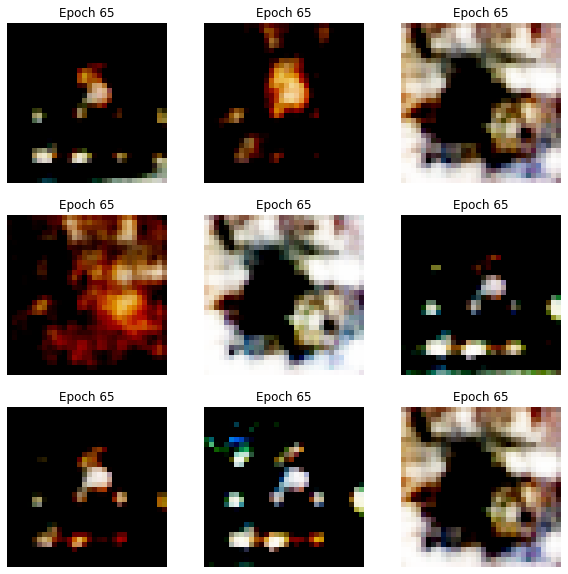

Epoch: 67 / 100   Descriminator Loss[1]: 0.047    Descriminator Loss[2]: 0.024    GAN loss: 0.158
Epoch: 68 / 100   Descriminator Loss[1]: 0.040    Descriminator Loss[2]: 0.041    GAN loss: 0.146
Epoch: 69 / 100   Descriminator Loss[1]: 0.462    Descriminator Loss[2]: 0.248    GAN loss: 4.006
Epoch: 70 / 100   Descriminator Loss[1]: 0.045    Descriminator Loss[2]: 0.357    GAN loss: 2.811


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 71 / 100   Descriminator Loss[1]: 0.161    Descriminator Loss[2]: 0.275    GAN loss: 2.986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


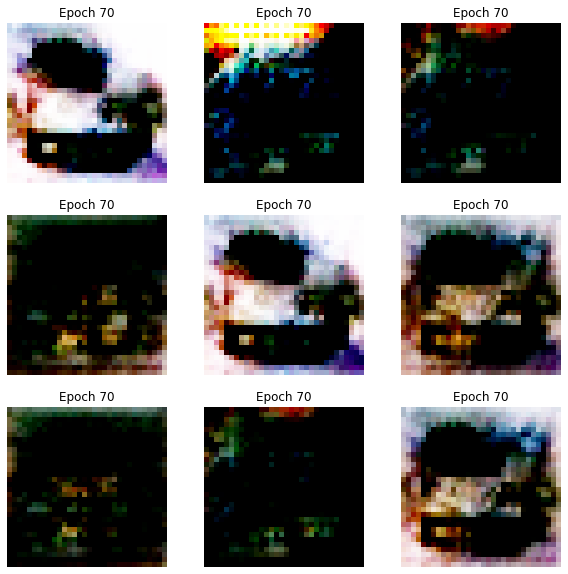

Epoch: 72 / 100   Descriminator Loss[1]: 0.256    Descriminator Loss[2]: 0.058    GAN loss: 0.352
Epoch: 73 / 100   Descriminator Loss[1]: 0.436    Descriminator Loss[2]: 0.146    GAN loss: 2.574
Epoch: 74 / 100   Descriminator Loss[1]: 0.161    Descriminator Loss[2]: 0.181    GAN loss: 1.812
Epoch: 75 / 100   Descriminator Loss[1]: 0.065    Descriminator Loss[2]: 0.072    GAN loss: 0.346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 76 / 100   Descriminator Loss[1]: 0.157    Descriminator Loss[2]: 0.127    GAN loss: 3.131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


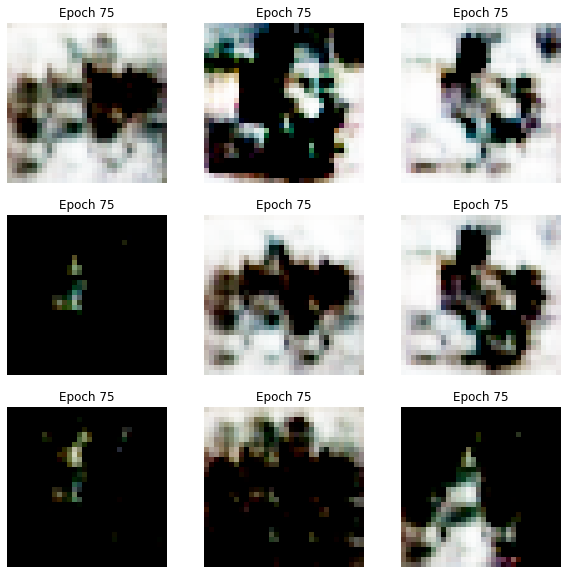

Epoch: 77 / 100   Descriminator Loss[1]: 0.122    Descriminator Loss[2]: 0.127    GAN loss: 2.511
Epoch: 78 / 100   Descriminator Loss[1]: 0.115    Descriminator Loss[2]: 0.130    GAN loss: 3.391
Epoch: 79 / 100   Descriminator Loss[1]: 0.263    Descriminator Loss[2]: 0.271    GAN loss: 3.404
Epoch: 80 / 100   Descriminator Loss[1]: 0.286    Descriminator Loss[2]: 0.081    GAN loss: 3.394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 81 / 100   Descriminator Loss[1]: 0.062    Descriminator Loss[2]: 0.020    GAN loss: 3.985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


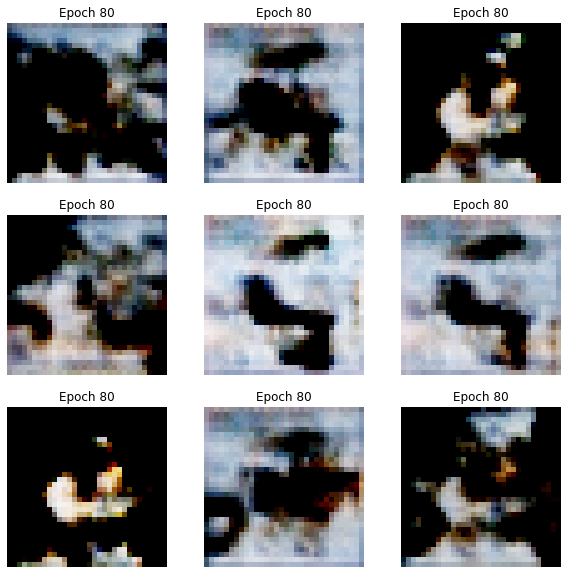

Epoch: 82 / 100   Descriminator Loss[1]: 0.239    Descriminator Loss[2]: 0.119    GAN loss: 2.463
Epoch: 83 / 100   Descriminator Loss[1]: 0.869    Descriminator Loss[2]: 0.258    GAN loss: 1.671
Epoch: 84 / 100   Descriminator Loss[1]: 0.072    Descriminator Loss[2]: 0.156    GAN loss: 3.119
Epoch: 85 / 100   Descriminator Loss[1]: 0.142    Descriminator Loss[2]: 0.080    GAN loss: 3.208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 86 / 100   Descriminator Loss[1]: 0.202    Descriminator Loss[2]: 0.124    GAN loss: 2.554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


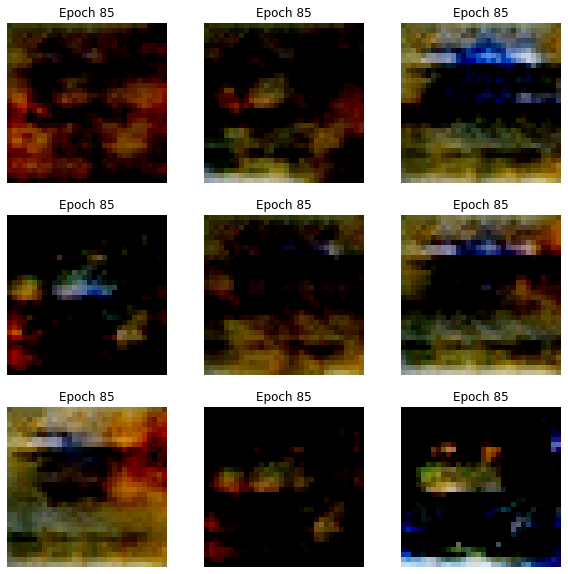

Epoch: 87 / 100   Descriminator Loss[1]: 0.454    Descriminator Loss[2]: 0.134    GAN loss: 1.271
Epoch: 88 / 100   Descriminator Loss[1]: 0.240    Descriminator Loss[2]: 0.045    GAN loss: 8.456
Epoch: 89 / 100   Descriminator Loss[1]: 0.048    Descriminator Loss[2]: 0.072    GAN loss: 5.322
Epoch: 90 / 100   Descriminator Loss[1]: 0.237    Descriminator Loss[2]: 0.076    GAN loss: 4.550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 91 / 100   Descriminator Loss[1]: 0.310    Descriminator Loss[2]: 0.059    GAN loss: 4.051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


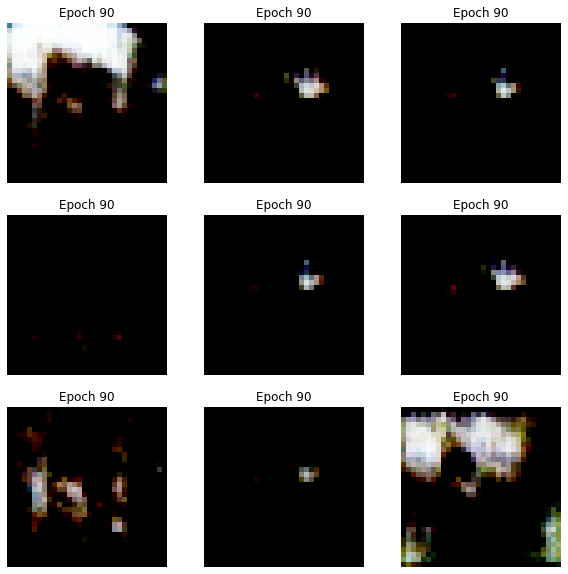

Epoch: 92 / 100   Descriminator Loss[1]: 0.286    Descriminator Loss[2]: 0.218    GAN loss: 2.789
Epoch: 93 / 100   Descriminator Loss[1]: 0.512    Descriminator Loss[2]: 0.471    GAN loss: 2.670
Epoch: 94 / 100   Descriminator Loss[1]: 0.163    Descriminator Loss[2]: 0.115    GAN loss: 3.258
Epoch: 95 / 100   Descriminator Loss[1]: 0.044    Descriminator Loss[2]: 0.048    GAN loss: 0.957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 96 / 100   Descriminator Loss[1]: 0.197    Descriminator Loss[2]: 0.199    GAN loss: 2.549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


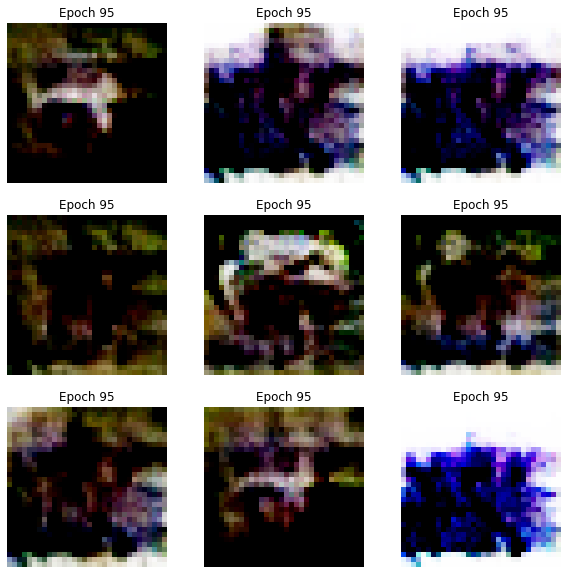

Epoch: 97 / 100   Descriminator Loss[1]: 0.119    Descriminator Loss[2]: 0.028    GAN loss: 0.196
Epoch: 98 / 100   Descriminator Loss[1]: 0.080    Descriminator Loss[2]: 0.044    GAN loss: 2.044


In [ ]:
train(g_model, d_model, gan_model, load_real_samples(), latent_dim)